In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
from scipy import spatial
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown
import numpy as np

In [2]:
import torch
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
%load_ext autoreload
%autoreload 2

# Load the dataset

In [4]:
scrna = sc.read('thesis/multigrate/data/hao-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 149926 × 27504
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'names', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [4]:
cite = sc.read('thesis/multigrate/data/hao-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 149926 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes'
    var: 'n_cells'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scrna2 = sc.read('thesis/multigrate/data/kotliarov-2020/expressions.h5ad')
scrna2

AnnData object with n_obs × n_vars = 52117 × 20245
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [6]:
cite2 = sc.read('thesis/multigrate/data/kotliarov-2020/protein.h5ad')
cite2

AnnData object with n_obs × n_vars = 52117 × 87
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

# Prep RNA-seq

In [8]:
len(set(scrna.var_names) & set(scrna2.var_names))

15301

In [9]:
common_genes = list(set(scrna.var_names) & set(scrna2.var_names))

In [10]:
scrna = scrna[:, common_genes]
scrna2 = scrna2[:, common_genes]

In [11]:
scrna = scrna[:5000]
cite = cite[:5000]

In [12]:
scrna2 = scrna2[:3000]
cite2 = cite2[:3000]

In [13]:
adata = scrna.concatenate(scrna2)
adata

AnnData object with n_obs × n_vars = 8000 × 15301
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [14]:
adata.X = adata.layers['count']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [16]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 8000 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 

In [17]:
adata1 = adata[adata.obs.batch == '0']
adata2 = adata[adata.obs.batch == '1']

In [18]:
adata1

View of AnnData object with n_obs × n_vars = 5000 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 

In [19]:
adata2

View of AnnData object with n_obs × n_vars = 3000 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 

In [20]:
adata1.obs['cell_type'] = adata1.obs['celltype.l1']
cite.obs['cell_type'] = cite.obs['celltype.l1']

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


# Prep ADT

In [10]:
double_names = []

for name in cite.var_names:
    if '-' in name and name.startswith('CD'):
        double_names.append(name.split('-')[0])
        
double_names = set(double_names)
double_names

{'CD11b',
 'CD133',
 'CD138',
 'CD26',
 'CD275',
 'CD3',
 'CD38',
 'CD4',
 'CD44',
 'CD45',
 'CD56'}

In [13]:
cite.var_names = [name.split('-')[0] for name in cite.var_names]
cite.var_names

Index(['CD39', 'Rat', 'CD107a', 'CD62P', 'TCR', 'CD30', 'CD31', 'CD34', 'CD35',
       'CD36',
       ...
       'CD169', 'CD28', 'CD161', 'CD163', 'CD138', 'CD164', 'CD138', 'CD144',
       'CD202b', 'CD11c'],
      dtype='object', length=228)

In [14]:
cite.var_names_make_unique()
cite.var_names

Index(['CD39', 'Rat', 'CD107a', 'CD62P', 'TCR', 'CD30', 'CD31', 'CD34', 'CD35',
       'CD36',
       ...
       'CD169', 'CD28', 'CD161', 'CD163', 'CD138', 'CD164', 'CD138-1', 'CD144',
       'CD202b', 'CD11c'],
      dtype='object', length=228)

In [11]:
tmp = []

for name in cite.var_names:
    if '-' in name:
        tmp.append(name.split('-')[0])

tmp = set(tmp)
tmp

{'B7',
 'CD11b',
 'CD133',
 'CD138',
 'CD26',
 'CD275',
 'CD3',
 'CD38',
 'CD4',
 'CD44',
 'CD45',
 'CD56',
 'Galectin',
 'HLA',
 'Integrin',
 'LOX',
 'Notch',
 'Rag',
 'Rat',
 'Siglec',
 'TCR',
 'TIM',
 'VEGFR'}

In [59]:
for name in cite2.var_names:
    for protein in tmp:
        if protein in name:
            print(name)

CD133_PROT
CD3_PROT
CD303_PROT
CD32_PROT
CD357_PROT
CD366_PROT
CD39_PROT
CD40_PROT
CD138_PROT
CD31_PROT
CD314 _PROT
CD38_PROT
CD38_PROT
CD4_PROT
CD45RA_PROT
CD45RA_PROT
CD56_PROT
CD275_PROT
CD45RO_PROT
CD45RO_PROT
CD11b_PROT
CD33_PROT
CD34_PROT


In [41]:
for name in cite.var_names:
    if '-' in name:
        print(name)

Rat-IgG1-1
TCR-2
TCR-V-9
Siglec-8
Rat-IgG2b
VEGFR-3
CD4-2
CD4-1
CD3-1
Galectin-9
Rat-IgG1-2
CD56-2
CD56-1
CD11b-1
CD11b-2
CD38-2
CD38-1
Rag-IgG2c
LOX-1
TIM-4
CD44-2
CD44-1
CD26-2
CD26-1
TCR-1
TCR-V-7.2
TCR-V-2
HLA-DR
Notch-1
Notch-2
CD275-2
CD275-1
CD45-2
CD45-1
CD133-2
CD133-1
TCR-V-24-J-18
Integrin-7
B7-H4
CD3-2
CD138-1
CD138-2


In [38]:
cite2.var_names

Index(['AnnexinV_PROT', 'BTLA_PROT', 'CD117_PROT', 'CD123_PROT', 'CD13_PROT',
       'CD133_PROT', 'CD134_PROT', 'CD137_PROT', 'CD141_PROT', 'CD152_PROT',
       'CD161_PROT', 'CD163_PROT', 'CD18_PROT', 'CD184_PROT', 'CD19_PROT',
       'CD1c_PROT', 'CD1d_PROT', 'CD2_PROT', 'CD206_PROT', 'CD21_PROT',
       'CD223_PROT', 'CD24_PROT', 'CD244_PROT', 'CD273_PROT', 'CD294_PROT',
       'CD3_PROT', 'CD303_PROT', 'CD32_PROT', 'CD357_PROT', 'CD366_PROT',
       'CD39_PROT', 'CD40_PROT', 'CD57_PROT', 'CD62L_PROT', 'CD64_PROT',
       'CD69_PROT', 'CD70_PROT', 'CD71_PROT', 'HLA-ABC_PROT', 'HLA-DR_PROT',
       'IgA_PROT', 'KLRG1_PROT', 'TCRgd_PROT', 'CX3CR1_PROT', 'CD10_PROT',
       'CD11c_PROT', 'CD138_PROT', 'CD14_PROT', 'CD16_PROT', 'CD185_PROT',
       'CD195_PROT', 'CD196_PROT', 'CD197_PROT', 'CD25_PROT', 'CD27_PROT',
       'CD278 _PROT', 'CD279_PROT', 'CD31_PROT', 'CD314 _PROT', 'CD38_PROT',
       'CD4_PROT', 'CD45RA_PROT', 'CD56_PROT', 'CD8_PROT', 'IgD_PROT',
       'IgM_PROT', 'Mouse

In [25]:
cite.var_names

Index(['CD39', 'Rat-IgG1-1', 'CD107a', 'CD62P', 'TCR-2', 'CD30', 'CD31',
       'CD34', 'CD35', 'CD36',
       ...
       'CD169', 'CD28', 'CD161', 'CD163', 'CD138-1', 'CD164', 'CD138-2',
       'CD144', 'CD202b', 'CD11c'],
      dtype='object', length=228)

In [15]:
cite2.var_names = [name.split('_')[0] for name in cite2.var_names]
cite2.var_names

Index(['AnnexinV', 'BTLA', 'CD117', 'CD123', 'CD13', 'CD133', 'CD134', 'CD137',
       'CD141', 'CD152', 'CD161', 'CD163', 'CD18', 'CD184', 'CD19', 'CD1c',
       'CD1d', 'CD2', 'CD206', 'CD21', 'CD223', 'CD24', 'CD244', 'CD273',
       'CD294', 'CD3', 'CD303', 'CD32', 'CD357', 'CD366', 'CD39', 'CD40',
       'CD57', 'CD62L', 'CD64', 'CD69', 'CD70', 'CD71', 'HLA-ABC', 'HLA-DR',
       'IgA', 'KLRG1', 'TCRgd', 'CX3CR1', 'CD10', 'CD11c', 'CD138', 'CD14',
       'CD16', 'CD185', 'CD195', 'CD196', 'CD197', 'CD25', 'CD27', 'CD278 ',
       'CD279', 'CD31', 'CD314 ', 'CD38', 'CD4', 'CD45RA', 'CD56', 'CD8',
       'IgD', 'IgM', 'MouseIgG1kappaisotype', 'MouseIgG2akappaisotype',
       'Mouse IgG2bkIsotype', 'RatIgG2bkIsotype', 'CD103', 'CD275', 'CD28',
       'CD45RO', 'CD5', 'CD90', 'CD11b', 'CD127', 'CD194', 'CD274', 'CD33',
       'CD7', 'CD80', 'CD86', 'CD183', 'CD34', 'CD20'],
      dtype='object')

In [16]:
common_protein = list(set(cite.var_names) & set(cite2.var_names))
len(common_protein)

66

In [23]:
cite = cite[:, common_protein]
cite2 = cite2[:, common_protein]

In [24]:
adata = cite.concatenate(cite2)
adata

AnnData object with n_obs × n_vars = 8000 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [25]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [26]:
adata.X = adata.layers['count']
adata = clr_normalize_each_cell(adata)

In [27]:
cite1 = adata[adata.obs.batch == '0']
cite2 = adata[adata.obs.batch == '1']

In [28]:
cite1

View of AnnData object with n_obs × n_vars = 5000 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [29]:
cite2

View of AnnData object with n_obs × n_vars = 3000 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

# Rename cell types

In [30]:
adata1.obs.cell_type = adata1.obs.cell_type.astype('category')
adata2.obs.cell_type = adata2.obs.cell_type.astype('category')
cite1.obs.cell_type = cite.obs.cell_type.astype('category')
cite2.obs.cell_type = cite2.obs.cell_type.astype('category')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [31]:
adata1.obs.cell_type.cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'], dtype='object')

In [32]:
adata2.obs.cell_type.cat.categories

Index(['B', 'CD4 memory T', 'CD4 naive', 'CD8 memory T', 'CD8 naive',
       'Classical monocytes and mDC', 'NK', 'Non-classical monocytes',
       'Unconventional T cells', 'pDC'],
      dtype='object')

In [33]:
new_adata2_cat = {
    'B': 'B', 
    'CD4 memory T': 'CD4 T',
    'CD4 naive': 'CD4 T',
    'CD8 memory T': 'CD8 T',
    'CD8 naive': 'CD8 T',
    'Classical monocytes and mDC': 'Mono', 
    'NK': 'NK', 
    'Non-classical monocytes': 'Mono',
    'Unconventional T cells': 'other T', 
    'pDC': 'DC'
}

In [34]:
new_cell_types = [new_adata2_cat[name] for name in adata2.obs.cell_type]

In [35]:
adata2.obs['old_cell_type'] = adata2.obs['cell_type']
adata2.obs['cell_type'] = new_cell_types
adata2.obs['cell_type'] = adata2.obs['cell_type'].astype('category')
adata2.obs['cell_type'].cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other T'], dtype='object')

In [36]:
new_cell_types_cite = [new_adata2_cat[name] for name in cite2.obs.cell_type]

In [37]:
cite2.obs['old_cell_type'] = cite2.obs['cell_type']
cite2.obs['cell_type'] = new_cell_types_cite
cite2.obs['cell_type'] = cite2.obs['cell_type'].astype('category')
cite2.obs['cell_type'].cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other T'], dtype='object')

# Configure and train the model

In [38]:
adata1

AnnData object with n_obs × n_vars = 5000 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 'X_pca',

In [39]:
adata2

AnnData object with n_obs × n_vars = 3000 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'old_cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
 

In [40]:
cite1

AnnData object with n_obs × n_vars = 5000 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [41]:
cite2

AnnData object with n_obs × n_vars = 3000 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [42]:
model = mtg.models.MultiVAE_PoE_small(
    adatas=[[adata1, adata2], [cite1]],
    names=[['rna1', 'rna2'], ['cite1']],
    pair_groups=[['pair1', 'pair2'], ['pair1']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count', 'count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=0,
    integ_coef=0,
    cycle_coef=0,
    dropout=0.2
)

In [43]:
model = mtg.models.MultiVAE_PoE_cond(
    adatas=[[adata1, adata2], [cite]],
    names=[['rna1', 'rna2'], ['cite1']],
    pair_groups=[['pair1', 'pair2'], ['pair1']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count', 'count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=0,
    integ_coef=0,
    cycle_coef=0,
    dropout=0.2
)

In [44]:
model = mtg.models.MultiVAE_PoE(
    adatas=[[adata1, adata2], [cite]],
    names=[['rna1', 'rna2'], ['cite1']],
    pair_groups=[['pair1', 'pair2'], ['pair1']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count', 'count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=0,
    integ_coef=0,
    cycle_coef=0,
    dropout=0.2
)

In [144]:
model = mtg.models.MultiVAE_PoE_small_mse(
    adatas=[[adata1, adata2], [cite]],
    names=[['rna1', 'rna2'], ['cite1']],
    pair_groups=[['pair1', 'pair2'], ['pair1']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count', 'count'], [None]],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2
)

In [145]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 0.9006, -0.6897, -1.7878,  1.4839,  0.0907,  0.6189,  0.9253,  0.4903,
         -2.2181, -1.3017, -1.5539,  0.0896, -0.1039,  0.0174, -0.7689],
        [ 0.9356,  0.7749,  0.1130,  0.8226, -0.1495, -1.4016,  0.2983,  0.0657,
          0.1941, -0.8723,  0.3726,  0.3552, -0.6871, -0.4192,  1.1170]],
       requires_grad=True)

In [146]:
1-spatial.distance.cosine(model.model.modality_vectors.weight[0].detach().numpy(),
                       model.model.modality_vectors.weight[1].detach().numpy())

0.010357608087360859

In [147]:
model.theta

tensor([[ 0.5834, -0.1553],
        [-1.4887,  0.7796],
        [-0.0224,  0.5658],
        ...,
        [-1.2052,  0.1846],
        [ 0.6522,  0.3232],
        [ 1.7334, -1.1738]], requires_grad=True)

In [148]:
model.train(
    n_iters=15000,
    #celltype_key='celltype.l1',
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=7500,
    validate_every=1500,
    correct='all', #missing, none, all
    kernel_type='gaussian',
    version='2'
)

 |████████████████████| 100.0% iter=15000/15000, time=147.83(s), loss=0.3777, recon=0.3718, kl=217.5982, integ=0.3753, cycle=0.0000, val_loss=0.3574, val_recon=0.3528, val_kl=215.2052, val_integ=0.2398, val_cycle=0.0000

In [149]:
model.theta

tensor([[ 0.0926, -2.7312],
        [ 0.9553, -1.8783],
        [-0.1449, -0.1748],
        ...,
        [-1.3231, -0.4887],
        [-0.6224, -0.9248],
        [ 1.0404, -2.8453]], requires_grad=True)

In [150]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 0.0064, -0.0002,  0.0023, -0.0215, -0.0862, -0.0123,  0.0582,  0.0585,
         -0.0071,  0.0167,  0.0365, -0.0509,  0.0239, -0.0275,  0.0161],
        [-0.0332,  0.0561, -0.0238, -0.0173,  0.0997, -0.0093, -0.0722, -0.0700,
         -0.1134, -0.0248, -0.0455,  0.0953, -0.0378,  0.0592,  0.0618]],
       requires_grad=True)

In [151]:
1-spatial.distance.cosine(model.model.modality_vectors.weight[0].detach().numpy(),
                       model.model.modality_vectors.weight[1].detach().numpy())

-0.6980127692222595

## Plot training history
Note that there's only one pair of datasets so we don't have the integration loss here.

In [152]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_kl,train_integ,train_cycle,mod_vec0_norm,cos_similarity_mod_vectors_0_1,mod_vec1_norm,val_loss,val_recon,val_recon_mse,val_recon_nb,val_kl,val_integ,val_cycle
0,1500,0.668450,0.645163,0.256021,0.181595,88.785743,2.317005,0.0,3.045938,-0.698013,1.572415,0.525180,0.508649,0.155458,0.166701,105.272568,1.632038,0
1,3000,0.504677,0.490673,0.144936,0.162755,118.205539,1.362456,0.0,2.178908,-0.698013,0.901198,0.440958,0.430998,0.099902,0.156281,118.153511,0.948721,0
2,4500,0.442565,0.433305,0.107337,0.153989,130.846567,0.857859,0.0,1.475908,-0.698013,0.595783,0.409859,0.402973,0.082679,0.151224,129.623459,0.610844,0
3,6000,0.425157,0.417459,0.092169,0.154218,142.624136,0.667010,0.0,0.911962,-0.698013,0.362828,0.391187,0.385719,0.072543,0.147800,143.589645,0.431883,0
4,7500,0.403436,0.396658,0.084116,0.147286,157.349606,0.532736,0.0,0.523122,-0.698013,0.250399,0.380719,0.375619,0.068222,0.145156,158.901642,0.351175,0
5,9000,0.399513,0.392530,0.081079,0.146205,173.140845,0.525085,0.0,0.277130,-0.698013,0.231694,0.371524,0.366714,0.063536,0.143132,175.820633,0.305131,0
6,10500,0.387786,0.381553,0.073356,0.144240,189.497815,0.433848,0.0,0.170050,-0.698013,0.240348,0.366656,0.361942,0.062086,0.141516,189.753906,0.281637,0
7,12000,0.380392,0.374157,0.073760,0.140359,198.135971,0.425282,0.0,0.144769,-0.698013,0.241016,0.362917,0.358253,0.061103,0.140259,201.458588,0.264920,0
8,13500,0.379144,0.372725,0.073291,0.140331,211.822601,0.430099,0.0,0.142919,-0.698013,0.244029,0.359279,0.354666,0.059333,0.139356,210.131607,0.251099,0
9,14999,0.377750,0.371820,0.071975,0.140782,217.598175,0.375347,0.0,0.143996,-0.698013,0.242180,0.357352,0.352802,0.058752,0.138716,215.205231,0.239774,0


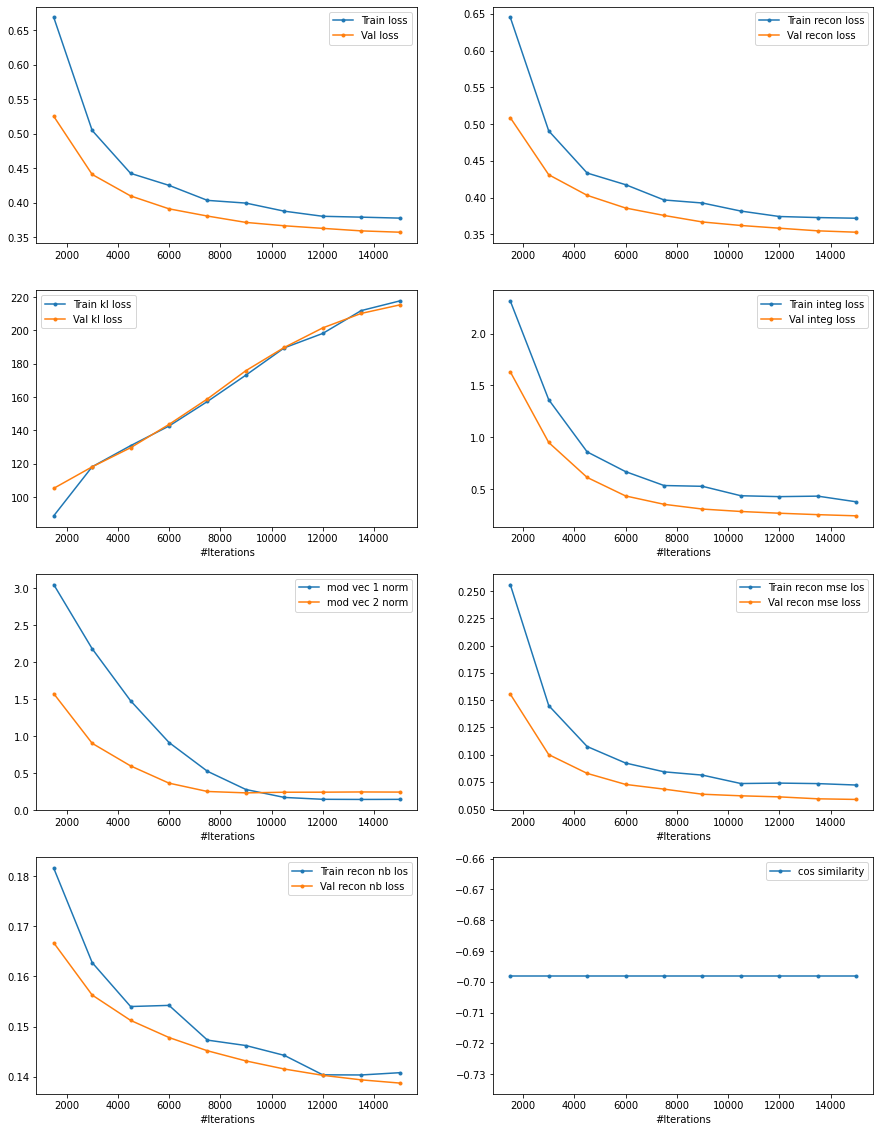

In [153]:
plt.figure(figsize=(15, 20));
plt.subplot(421);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(422);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(423);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(424);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(425);
plt.plot(model.history['iteration'], model.history['mod_vec0_norm'], '.-', label='mod vec 1 norm');
plt.plot(model.history['iteration'], model.history['mod_vec1_norm'], '.-', label='mod vec 2 norm');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(426);
plt.plot(model.history['iteration'], model.history['train_recon_mse'], '.-', label='Train recon mse los');
plt.plot(model.history['iteration'], model.history['val_recon_mse'], '.-', label='Val recon mse loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(427);
plt.plot(model.history['iteration'], model.history['train_recon_nb'], '.-', label='Train recon nb los');
plt.plot(model.history['iteration'], model.history['val_recon_nb'], '.-', label='Val recon nb loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(428);
plt.plot(model.history['iteration'], model.history['cos_similarity_mod_vectors_0_1'], '.-', label='cos similarity');
plt.xlabel('#Iterations');
plt.legend();

# Validation

In [154]:
out = model.test(adatas=[[adata1, adata2], [cite]],
    names=[['rna1', 'rna2'], ['cite1']],
    pair_groups=[['pair1', 'pair2'], ['pair1']],
    layers=[['count', 'count'], [None]],
    batch_size=64,
)

In [155]:
hs, latent, corrected, joint = out

In [156]:
corrected

AnnData object with n_obs × n_vars = 13000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [157]:
latent

AnnData object with n_obs × n_vars = 13000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [158]:
hs

AnnData object with n_obs × n_vars = 13000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [159]:
joint

AnnData object with n_obs × n_vars = 5000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [160]:
sc.pp.neighbors(corrected)
sc.tl.umap(corrected)

In [161]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [162]:
sc.pp.neighbors(hs)
sc.tl.umap(hs)

In [163]:
sc.pp.neighbors(joint)
sc.tl.umap(joint)

In [164]:
hs.obs['modality'] = hs.obs['modality'].astype('str')
hs.obs['batch'] = hs.obs['study'] + '-modality-' + hs.obs['modality']
hs.obs['modality'] = hs.obs['modality'].astype('category')
hs.obs['batch'] = hs.obs['batch'].astype('category')

In [165]:
corrected.obs['modality'] = corrected.obs['modality'].astype('str')
corrected.obs['batch'] = corrected.obs['study'] + '-modality-' + corrected.obs['modality']
corrected.obs['modality'] = corrected.obs['modality'].astype('category')
corrected.obs['batch'] = corrected.obs['batch'].astype('category')

In [166]:
latent.obs['modality'] = latent.obs['modality'].astype('str')
latent.obs['batch'] = latent.obs['study'] + '-modality-' + latent.obs['modality']
latent.obs['modality'] = latent.obs['modality'].astype('category')
latent.obs['batch'] = latent.obs['batch'].astype('category')

In [167]:
joint.obs['modality'] = joint.obs['modality'].astype('str')
joint.obs['batch'] = joint.obs['study'] + '-modality-' + joint.obs['modality']
joint.obs['modality'] = joint.obs['modality'].astype('category')
joint.obs['batch'] = joint.obs['batch'].astype('category')

... storing 'study' as categorical
... storing 'cell_type' as categorical


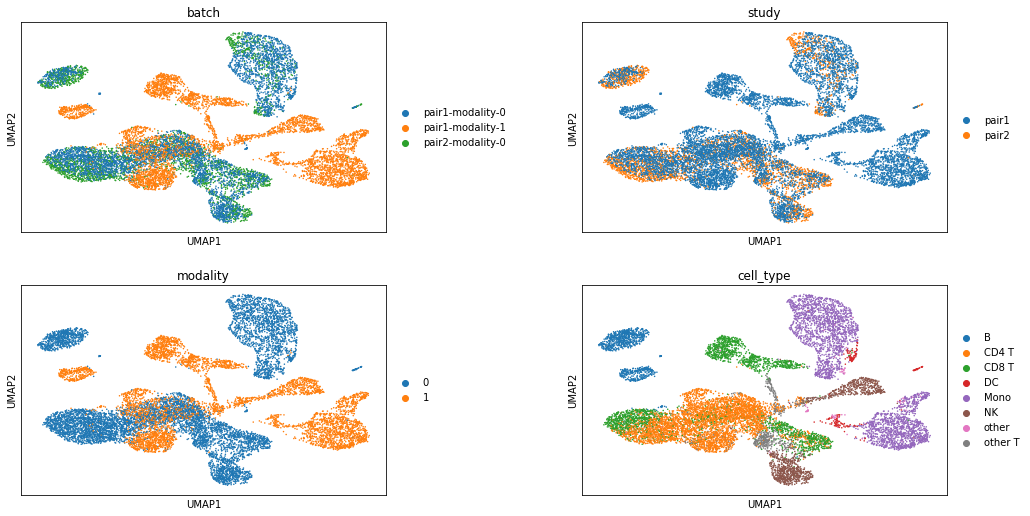

In [168]:
sc.pl.umap(hs, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

... storing 'barcode' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


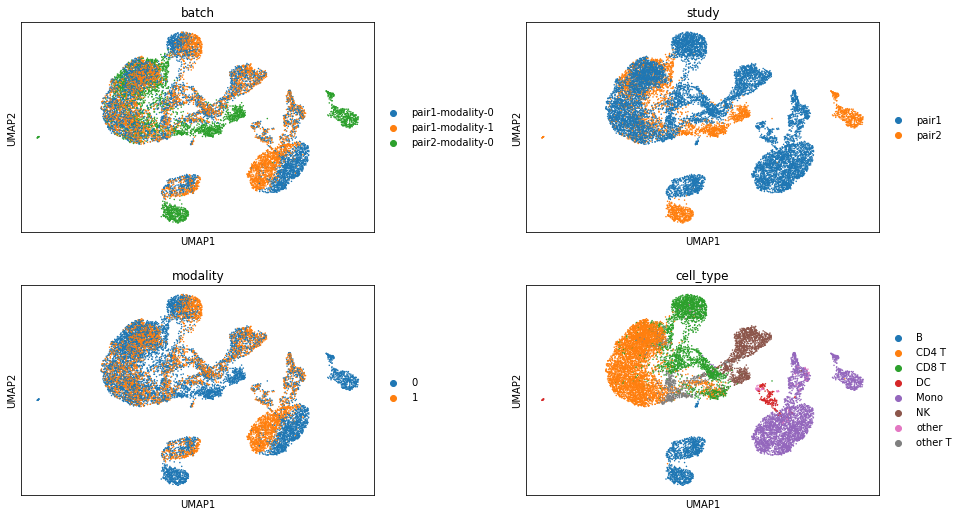

In [169]:
sc.pl.umap(corrected, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.3)

... storing 'study' as categorical
... storing 'cell_type' as categorical


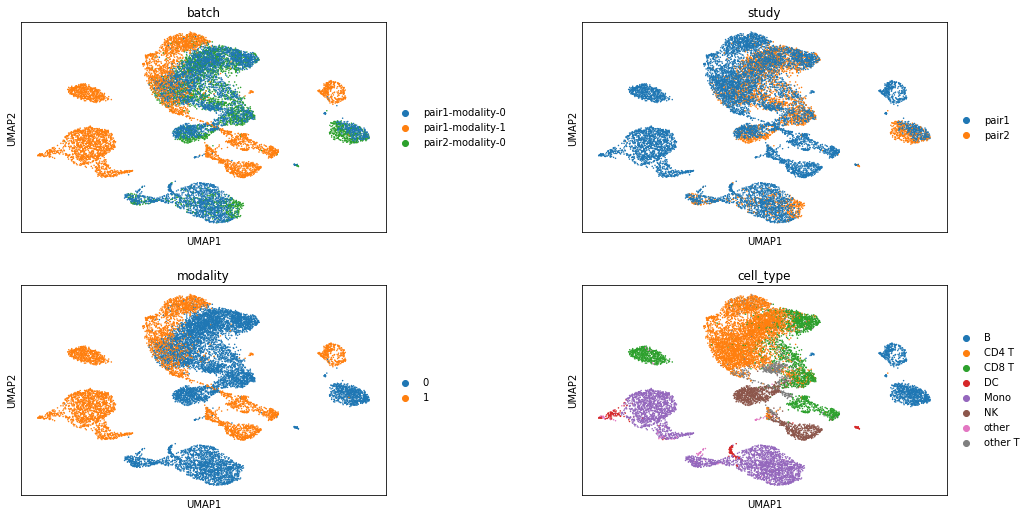

In [170]:
sc.pl.umap(latent, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

... storing 'study' as categorical
... storing 'cell_type' as categorical


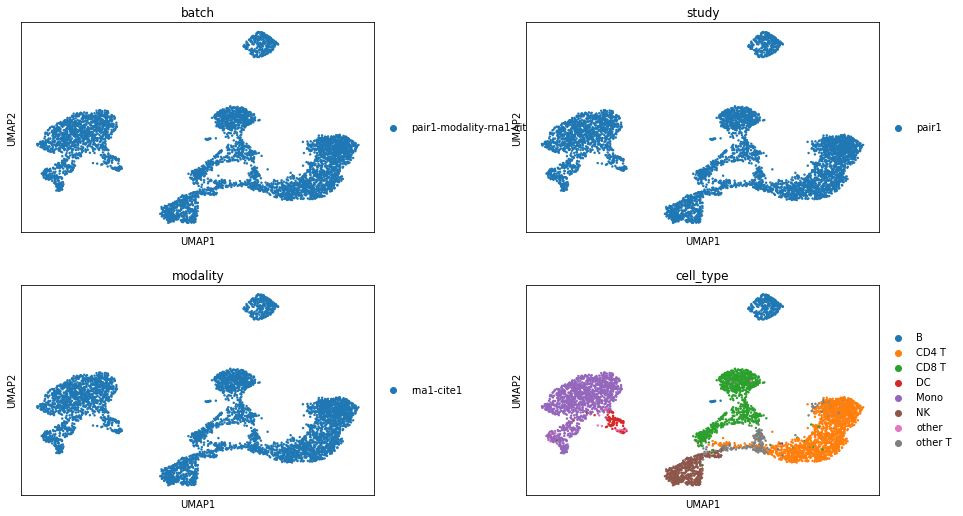

In [171]:
sc.pl.umap(joint, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.3)

In [172]:
joint.obs['batch'] = 'pair1-joint'

In [173]:
adata = latent.concatenate(joint, batch_key='concat')
adata

AnnData object with n_obs × n_vars = 18000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch', 'concat'
    obsm: 'X_umap'

In [174]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [175]:
adata.obs['modality'] = adata.obs['modality'].astype('category').cat.rename_categories({'0': 'rna', '1': 'cite', 'rna1-cite1': 'joint'}) 

... storing 'barcode' as categorical
... storing 'study' as categorical
... storing 'batch' as categorical


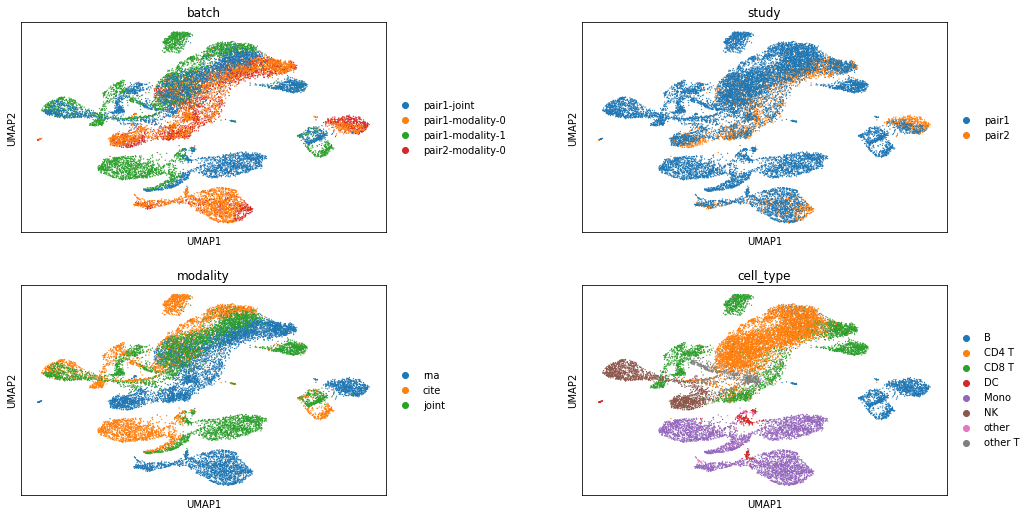

In [176]:
sc.pl.umap(adata, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

In [177]:
adata = adata[(adata.obs.batch == 'pair1-joint') | (adata.obs.batch == 'pair2-modality-0')]
adata

View of AnnData object with n_obs × n_vars = 8000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch', 'concat'
    uns: 'neighbors', 'umap', 'batch_colors', 'study_colors', 'modality_colors', 'cell_type_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [178]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

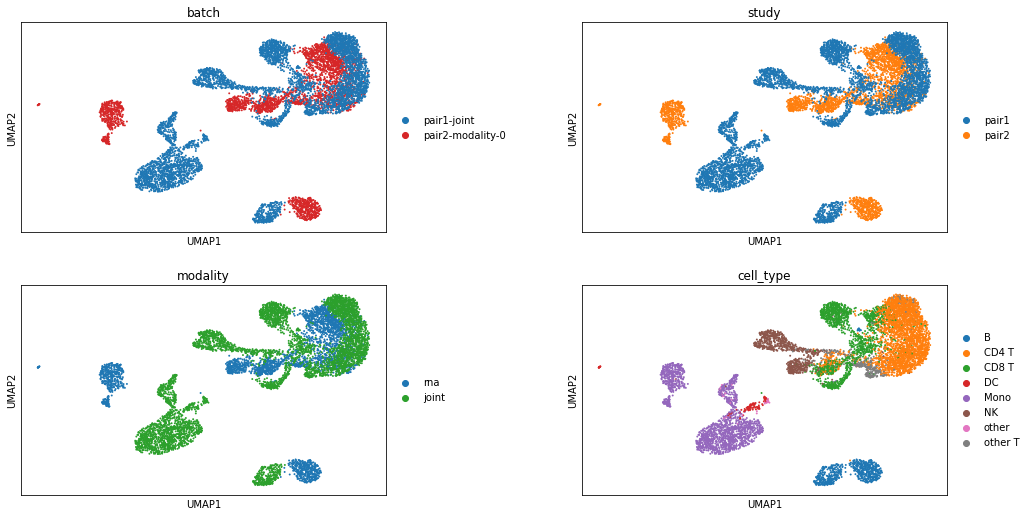

In [179]:
sc.pl.umap(adata, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

# Impute

In [80]:
protein_pred = model.impute(
        adatas = [[adata2], []],
        names = [['rna2'], []],
        pair_groups = [['pair2'], []],
        target_modality = 1,
        batch_labels = [[1], []],
        target_pair = None,
        layers=[['count'], []],
        batch_size=64,
    )

In [81]:
protein_pred.obsm['predicted_protein'] = protein_pred.X
protein_pred

AnnData object with n_obs × n_vars = 3000 × 59
    obs: 'modality', 'barcode', 'cell_type', 'batch'
    obsm: 'predicted_protein'

In [82]:
cite2.obsm['protein'] = cite2.X
cite2

AnnData object with n_obs × n_vars = 3000 × 59
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap', 'protein'
    layers: 'count'

In [83]:
from scipy.stats import pearsonr

protein_corrs = []
for i, protein in enumerate(cite2.var_names):
   # protein = protein[:-10]
    protein_corrs.append(protein + ': Corr=' + str(np.round(pearsonr(protein_pred.obsm['predicted_protein'][:, i], cite2.obsm['protein'][:, i])[0], 3)))
    
protein_corrs

['CD244: Corr=0.841',
 'CD194: Corr=0.411',
 'CD137: Corr=0.082',
 'CD366: Corr=0.398',
 'CD27: Corr=0.864',
 'CD8: Corr=0.731',
 'CD71: Corr=0.454',
 'CD303: Corr=0.216',
 'CD16: Corr=0.786',
 'CD25: Corr=0.422',
 'CD195: Corr=0.56',
 'CD123: Corr=0.497',
 'CD274: Corr=0.114',
 'CD223: Corr=0.062',
 'CX3CR1: Corr=0.416',
 'CD127: Corr=0.814',
 'CD21: Corr=0.894',
 'CD31: Corr=0.795',
 'CD357: Corr=0.19',
 'CD34: Corr=0.401',
 'CD28: Corr=0.898',
 'CD134: Corr=0.289',
 'CD24: Corr=0.484',
 'CD19: Corr=0.924',
 'CD294: Corr=0.07',
 'CD39: Corr=0.802',
 'CD161: Corr=0.657',
 'CD141: Corr=0.734',
 'CD57: Corr=0.507',
 'CD14: Corr=0.401',
 'CD279: Corr=0.455',
 'CD2: Corr=0.887',
 'CD11c: Corr=0.879',
 'CD69: Corr=0.466',
 'CD18: Corr=0.783',
 'CD70: Corr=0.033',
 'CD1d: Corr=0.736',
 'CD13: Corr=0.649',
 'CD45RO: Corr=0.71',
 'CD185: Corr=0.751',
 'CD80: Corr=0.023',
 'IgD: Corr=0.868',
 'CD152: Corr=0.025',
 'HLA-DR: Corr=0.868',
 'CD184: Corr=0.133',
 'CD90: Corr=0.021',
 'CD273: Corr=0